<a href="https://colab.research.google.com/github/matthewpecsok/6482/blob/main/tutorials/decision_tree_sklearn_titanic_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

decision tree titanic tutorial

Matthew Pecsok 2025

## table of contents

1.   Data Description
2.   Set up, data import and inspections
3.   Build decision trees
4.   Post-model-building data exploration
5.   Generate performance metrics
6.   Simple hold-out evaluation
7.   Tree pruning/unpruning



# 1 Data Description
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people such as women, children, and the upper-class were more likely to survive than others.

VARIABLE DESCRIPTIONS:

PassengerID Unique passenger identifier Survived Survival (0 = No; 1 = Yes) Pclass Passenger Class(1 = 1st; 2 = 2nd; 3 = 3rd) (Pclass is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower) Name Name Sex Sex Age Age (Age is in Years; Fractional if Age less than One (1) If the Age is Estimated, it is in the form xx.5) Sibsp Number of Siblings/Spouses Aboard Parch Number of Parents/Children Aboard Ticket Ticket Number Fare Passenger Fare Cabin Cabin Embarked Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

# 2 Set up, data import and inspections

## load libraries

In [1]:
## Load packages

import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt



## import data

In [2]:
# read_csv has some defaults, we can just take the defaults here, but be aware they exist.
titanic_raw = pd.read_csv("https://raw.githubusercontent.com/matthewpecsok/4482_fall_2024/main/data/titanic_cleaned.csv")
titanic = titanic_raw.copy()

# raw is the original unedited version of our data which can be useful for inspecting changes we've made
# compared to the original unedited data

## get summary statistics of dataframe

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Pclass    714 non-null    int64  
 2   Sex       714 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    int64  
 5   Parch     714 non-null    int64  
 6   Fare      714 non-null    float64
 7   Cabin     714 non-null    object 
 8   Embarked  714 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 50.3+ KB


In [4]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,missing,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,missing,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,missing,S


In [5]:
titanic.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,714.000000,714.000000,714,714.000000,714.000000,714.000000,714.000000,714,714
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,135,4
top,NaN,NaN,male,NaN,NaN,NaN,NaN,missing,S
freq,NaN,NaN,453,NaN,NaN,NaN,NaN,529,554
mean,0.406162,2.236695,NaN,29.699118,0.512605,0.431373,34.694514,NaN,NaN
std,0.491460,0.838250,NaN,14.526497,0.929783,0.853289,52.918930,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,1.000000,NaN,20.125000,0.000000,0.000000,8.050000,NaN,NaN
50%,0.000000,2.000000,NaN,28.000000,0.000000,0.000000,15.741700,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,1.000000,33.375000,NaN,NaN


In [6]:
# count null values (extremely important to identify nulls)

titanic.isnull().sum()

# no nulls, that's good news and almost never what happens in the real world.

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Cabin,0
Embarked,0


## transform character/string to categorical (factor in R)

In [7]:
# astype is function in pandas that allows one to convert from one type of data to another ie string to int, or in this
# case string to categorical
# https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html

titanic = titanic.astype({'Survived': 'category',
                                          'Sex': 'category',
                                          'Pclass': 'category',
                                          'Cabin': 'category',
                                          'Embarked': 'category'})
titanic.dtypes

,0
Survived,category
Pclass,category
Sex,category
Age,float64
SibSp,int64
Parch,int64
Fare,float64
Cabin,category
Embarked,category


## dummy encode the data

these models cannot handle string/words. they must be converted to numeric values

In [8]:
# extract the target column of survived. target aka y
# while R is happy to have the target in the dataframe with the X predictors sklearn prefers them separate
y_target = titanic.pop('Survived')

# use pandas get_dummies to one-hot-encode categorical values
# we would expect only numeric values left in our dataframe
# rename this df as encoded so we understand it's the encoded version
# of the original
titanic_encoded_X = pd.get_dummies(titanic)

titanic_encoded_X.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A10,...,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Cabin_T,Cabin_missing,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,22.0,1,0,7.2500,False,False,True,False,True,False,...,False,False,False,False,False,True,False,False,True,False
1,38.0,1,0,71.2833,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
2,26.0,0,0,7.9250,False,False,True,True,False,False,...,False,False,False,False,False,True,False,False,True,False
3,35.0,1,0,53.1000,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,35.0,0,0,8.0500,False,False,True,False,True,False,...,False,False,False,False,False,True,False,False,True,False


In [9]:
# lucky for us the binary target values are already numeric ie 0,1 instead of "yes","no" "true","false" etc
# this saves us a step of having to encode the series.
y_target

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
709,0
710,0
711,1
712,1


# 3 build decision trees

In [10]:
# random state
# set random state for all models for reproducbility
# if this is NOT set then you will see variations each time you run the model
# for this reason reproducibility is desirable in homeworks
random_state = 42

In [11]:
# what is tree?
tree

# an instance of a sklearn tree classifier

<module 'sklearn.tree' from '/usr/local/lib/python3.11/dist-packages/sklearn/tree/__init__.py'>

In [12]:
tree_model_1 = tree.DecisionTreeClassifier(random_state=random_state,max_leaf_nodes=11)
tree_model_1

DecisionTreeClassifier(max_leaf_nodes=11, random_state=42)

## model 1 (all data)

### fit/train the model

In [13]:
# model 1 is a model trained on all the data. subsequent models will be variations of this model and should be compared to understand how these changes impact the model.

In [14]:
# note, there is a lot going on behind the scenes here fitting is a complex process
# the first argument is a dataset of the predictors. the second is a series of the target or y variable.
tree_model_1 = tree_model_1.fit(titanic_encoded_X,y_target) # this trains the model on the x and y data

# check to see if the model is fited
sklearn.utils.validation.check_is_fitted(tree_model_1) # only get output if model is not fitted

### see a textual view of the model

In [15]:
print(tree.export_text(tree_model_1,feature_names=titanic_encoded_X.columns.to_list()))

|--- Sex_male <= 0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- Cabin_C22 C26 <= 0.50
|   |   |   |--- class: 1
|   |   |--- Cabin_C22 C26 >  0.50
|   |   |   |--- class: 0
|   |--- Pclass_3 >  0.50
|   |   |--- Fare <= 20.80
|   |   |   |--- Age <= 16.50
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  16.50
|   |   |   |   |--- class: 0
|   |   |--- Fare >  20.80
|   |   |   |--- class: 0
|--- Sex_male >  0.50
|   |--- Cabin_missing <= 0.50
|   |   |--- Age <= 17.50
|   |   |   |--- class: 1
|   |   |--- Age >  17.50
|   |   |   |--- Age <= 43.00
|   |   |   |   |--- class: 0
|   |   |   |--- Age >  43.00
|   |   |   |   |--- class: 0
|   |--- Cabin_missing >  0.50
|   |   |--- Age <= 3.50
|   |   |   |--- SibSp <= 2.00
|   |   |   |   |--- class: 1
|   |   |   |--- SibSp >  2.00
|   |   |   |   |--- class: 0
|   |   |--- Age >  3.50
|   |   |   |--- class: 0



### plot the tree

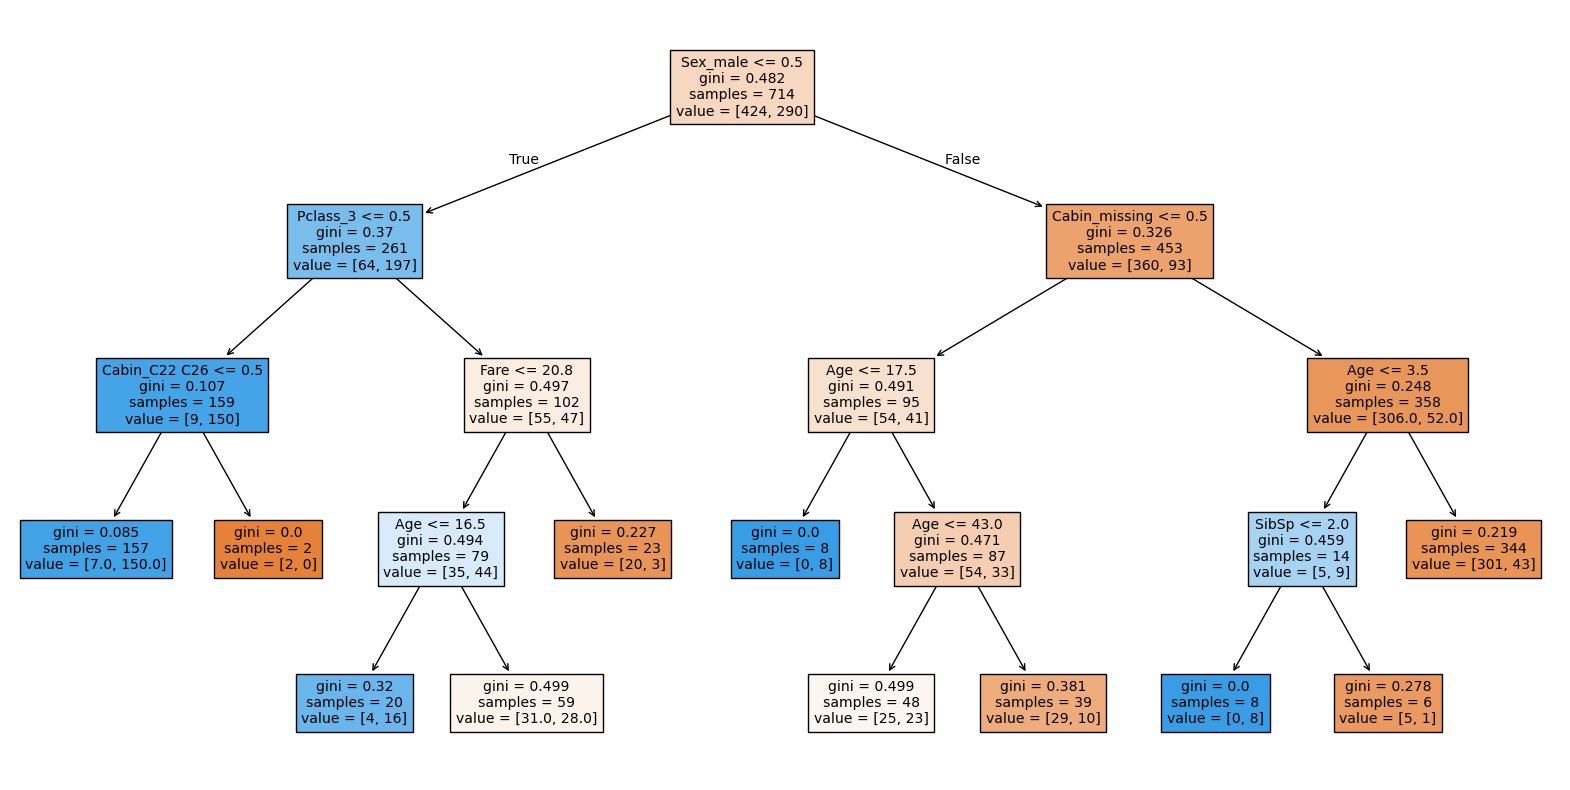

In [16]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(tree_model_1,
                   feature_names=titanic_encoded_X.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the class. shading indicates proportion or quality of split

## model 2 (all data but with cabin removed)

In [17]:
# demonstrating how to drop all columns starting with "Cabin"
titanic_encoded_X.drop(titanic_encoded_X.columns[titanic_encoded_X.columns.str.startswith('Cabin')], axis=1, inplace=False)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,22.0,1,0,7.2500,False,False,True,False,True,False,False,True,False
1,38.0,1,0,71.2833,True,False,False,True,False,True,False,False,False
2,26.0,0,0,7.9250,False,False,True,True,False,False,False,True,False
3,35.0,1,0,53.1000,True,False,False,True,False,False,False,True,False
4,35.0,0,0,8.0500,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,39.0,0,5,29.1250,False,False,True,True,False,False,True,False,False
710,27.0,0,0,13.0000,False,True,False,False,True,False,False,True,False
711,19.0,0,0,30.0000,True,False,False,True,False,False,False,True,False
712,26.0,0,0,30.0000,True,False,False,False,True,True,False,False,False


In [18]:
# create a new model 2
tree_model_2 = tree.DecisionTreeClassifier(random_state=random_state,max_leaf_nodes=11)
tree_model_2

# intentionally drop the cabin column. pay attention to the decision to do this
# if we drop a column should it increase or decrease model performance? Can you know this ahead of time?
titanic_encoded_X_no_cabin = titanic_encoded_X.drop(titanic_encoded_X.columns[titanic_encoded_X.columns.str.startswith('Cabin')], axis=1, inplace=False)


# note, there is a lot going on behind the scenes here fitting is a complex process
tree_model_2 = tree_model_2.fit(titanic_encoded_X_no_cabin,y_target) # this trains the model on the x and y data

# check to see if the model is fitted
sklearn.utils.validation.check_is_fitted(tree_model_2) # only get output if model is not fitted


### plot the tree

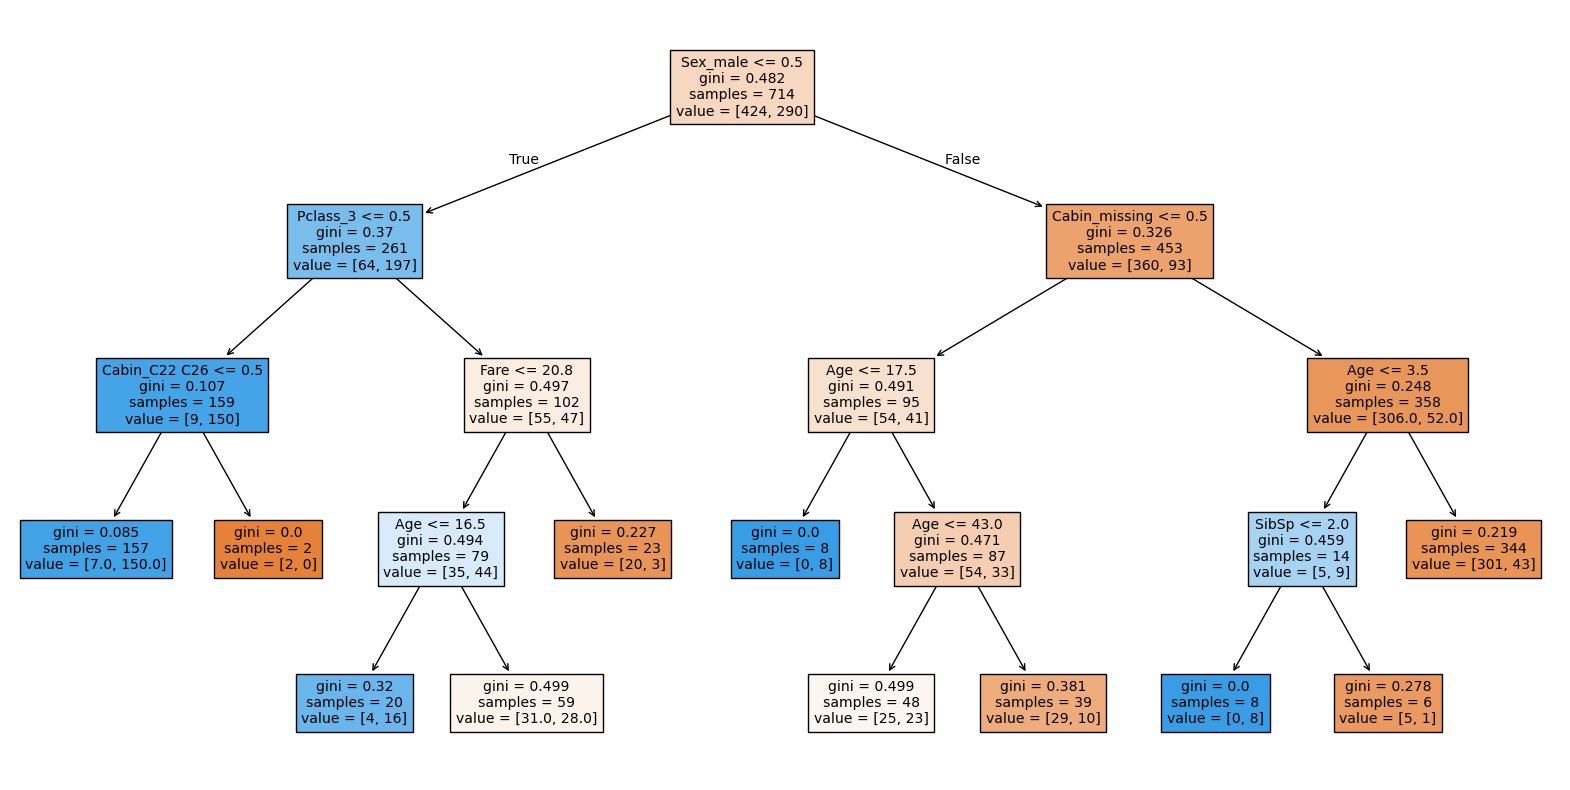

In [19]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(tree_model_1,
                   feature_names=titanic_encoded_X.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the class. shading indicates proportion or quality of split

# 4 Post-model-building data exploration

In [20]:
# generate metrics for male and female passengers. in this notebook we will demonstrate doing what was done in R,
# but in this case we will use a function to simplify the code
# often when doing the same thing 2 or more times a function can reduce redundant code

In [21]:
titanic[titanic['Sex']=='male'] # demonstration of how to filter a dataframe

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,missing,S
4,3,male,35.0,0,0,8.0500,missing,S
5,1,male,54.0,0,0,51.8625,E46,S
6,3,male,2.0,3,1,21.0750,missing,S
11,3,male,20.0,0,0,8.0500,missing,S
...,...,...,...,...,...,...,...,...
707,2,male,28.0,0,0,10.5000,missing,S
708,3,male,25.0,0,0,7.0500,missing,S
710,2,male,27.0,0,0,13.0000,missing,S
712,1,male,26.0,0,0,30.0000,C148,C


In [22]:
def metrics_by_gender(gender,df):
  # filter df by gender
  display("Dataframe subset of: "+gender)

  df = df[df['Sex']==gender]

  print(gender+": shape")
  display(df.shape)

  print(gender+": describe")
  display(df.describe())


In [23]:
# demonstration of a very simple function that just subsets the dataframe and prints the new shape
for gender in ['male','female']:
  df = titanic[titanic['Sex']==gender]
  print(gender)
  print(df.shape)
  print()

male
(453, 8)

female
(261, 8)



In [24]:
# demonstration of a very simple function that just subsets the dataframe and prints the new shape
for gender in ['male','female']:
  df = titanic[titanic['Sex']==gender]
  print(gender)
  print(df.describe())
  print()

male
              Age       SibSp       Parch        Fare
count  453.000000  453.000000  453.000000  453.000000
mean    30.726645    0.439294    0.271523   27.268836
std     14.678201    0.923609    0.651076   45.841889
min      0.420000    0.000000    0.000000    0.000000
25%     21.000000    0.000000    0.000000    7.895800
50%     29.000000    0.000000    0.000000   13.000000
75%     39.000000    1.000000    0.000000   28.500000
max     80.000000    5.000000    5.000000  512.329200

female
              Age       SibSp       Parch        Fare
count  261.000000  261.000000  261.000000  261.000000
mean    27.915709    0.639847    0.708812   47.582759
std     14.110146    0.928493    1.066752   61.346854
min      0.750000    0.000000    0.000000    6.750000
25%     18.000000    0.000000    0.000000   13.000000
50%     27.000000    0.000000    0.000000   26.000000
75%     37.000000    1.000000    1.000000   57.979200
max     63.000000    5.000000    6.000000  512.329200



In [25]:
# demonstration of a very simple function that just subsets the dataframe and prints the new shape
for gender in ['male','female']:
  df = titanic_raw[titanic_raw['Sex']==gender]
  print(gender)
  #print(df.groupby('Survived').value_counts())
  print(df.groupby(['Survived','Pclass'])[['Pclass']].agg(['count']))
  print()

male
                Pclass
                 count
Survived Pclass       
0        1          61
         2          84
         3         215
1        1          40
         2          15
         3          38

female
                Pclass
                 count
Survived Pclass       
0        1           3
         2           6
         3          55
1        1          82
         2          68
         3          47



In [26]:
for gender in ['male','female']:
  df = titanic_raw[titanic_raw['Sex']==gender]
  print(gender)
  #print(df.groupby('Survived').value_counts())
  print(df.groupby(['Survived','Embarked'])[['Embarked']].agg(['count']))
  print()

male
                  Embarked
                     count
Survived Embarked         
0        C              45
         Q              15
         S             300
1        C              24
         Q               1
         S              68

female
                  Embarked
                     count
Survived Embarked         
0        C               6
         Q               5
         S              53
1        C              55
         Q               7
         S             133
         missing         2



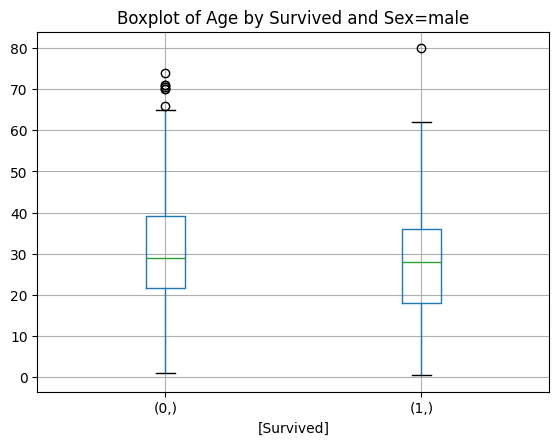

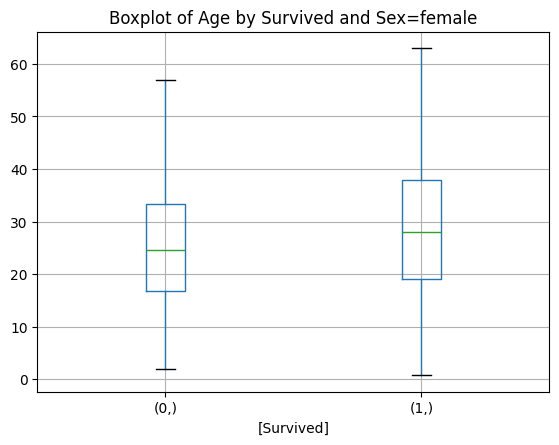

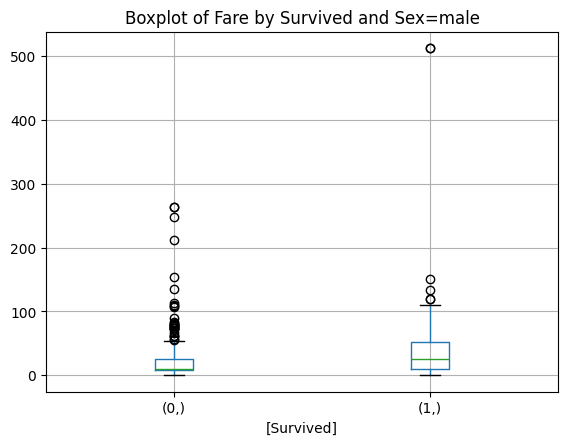

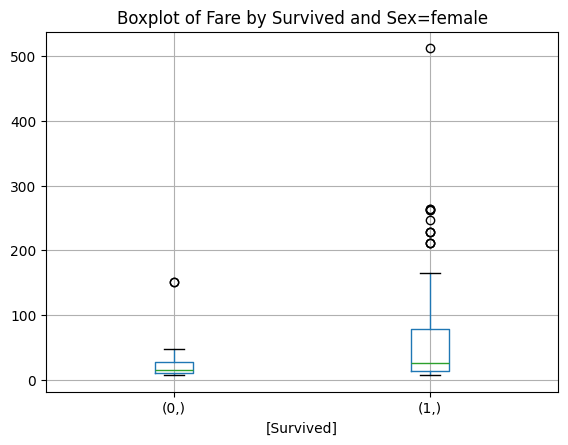

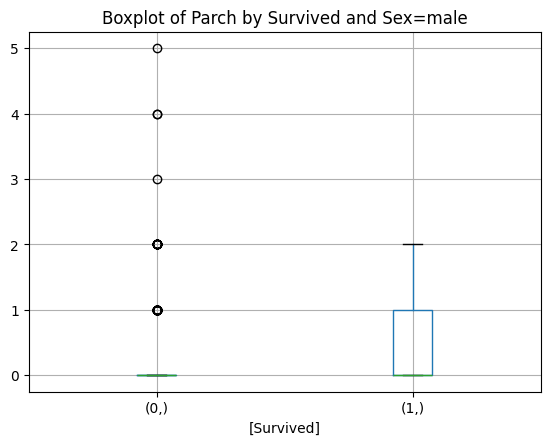

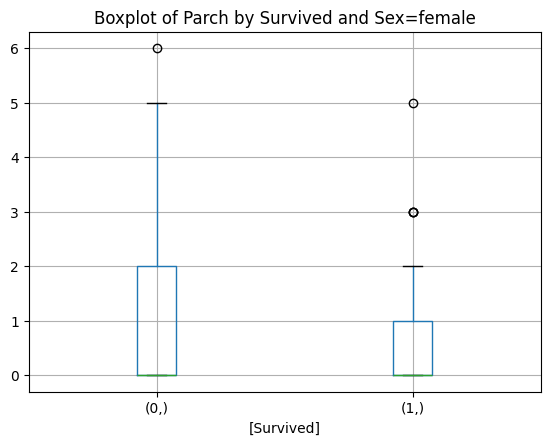

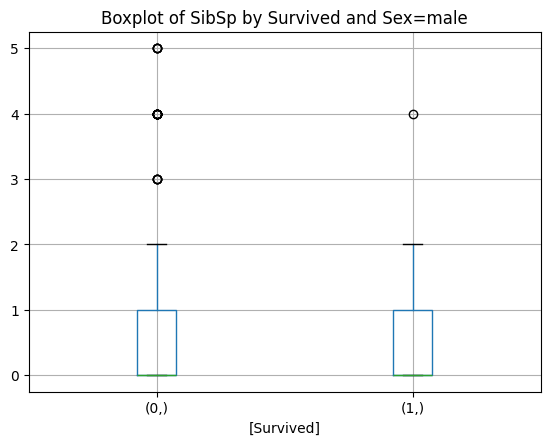

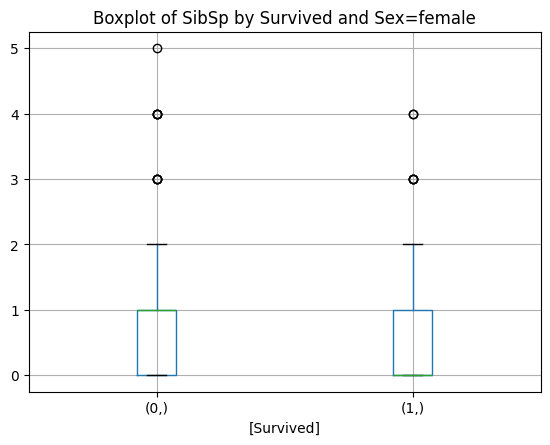

In [27]:
# demonstrating a nested for loop
# be careful of going much deeper than this in a loop
# the code becomes very difficult to read
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   # ignore some ugly warnings because of code that is being deprecated

for numeric_var in ['Age','Fare','Parch','SibSp']:
  for gender in ['male','female'] :
    df = titanic_raw[titanic_raw['Sex']==gender]
    df.boxplot(column=[numeric_var],by=['Survived']) # R boxplot(Age~Survived, data = titanic)
    plt.title( 'Boxplot of %s by Survived and Sex=%s' % (numeric_var,gender) )
    plt.suptitle('')
    plt.show()


# 5 Generate performance metrics

In [28]:
# predict() applies a model (1st argument) to a testing data set (2nd argument).
# Let's apply it to the whole data set that was used to train the model
# to see the model's performance metrics in training data (i.e., not holdout evaluation)
# Take a look at the structure and summary of predicted_Survived_w1 to understand the output of predict()

In [29]:
# create a confusion matrix comparing y_true and y_predicted
model_1_pred = tree_model_1.predict(titanic_encoded_X)

print(model_1_pred)
print(model_1_pred.shape)
# pay attention to the predictions. how does the model choose 0 or 1 for the predictions? What is going on under the hood here?



[0 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0
 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0
 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 1 0 0 1 0 0 0 0 0 

In [30]:
predicted_probs = tree_model_1.predict_proba(titanic_encoded_X)


In [31]:
pd.DataFrame(data={'predicted_class':model_1_pred,'predicted_probability':predicted_probs[:,0],'real_class':y_target})
# so what's the relationship between the class and the probability?
# nothing more than if prob >.5 then 0 else 1
# can you see how we might begin to quantify how wrong a given prediction is from the truth?
# when the model is uncertain we can expect the probability to be close to .5 in that case can
# you see the model is getting the answer wrong? Is that surprising?

,predicted_class,predicted_probability,real_class
0,0,0.875000,0
1,1,0.044586,1
2,0,0.525424,1
3,1,0.044586,1
4,0,0.875000,0
...,...,...,...
709,0,0.869565,0
710,0,0.875000,0
711,1,0.044586,1
712,0,0.520833,1


In [32]:
print(len(model_1_pred))



714


In [33]:
model_1_cf = confusion_matrix(y_true=y_target,y_pred=model_1_pred)
model_1_cf

array([[413,  11],
       [108, 182]])

### model 1 & 2 performance metrics

In [34]:
model_2_pred = tree_model_2.predict(titanic_encoded_X_no_cabin)

print(model_2_pred)



[0 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0
 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0
 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 1 0 0 1 0 0 1 0 0 0 0 0 

In [35]:
print(len(model_2_pred))

714


In [36]:
model_2_cf = confusion_matrix(y_true=y_target,y_pred=model_2_pred)
model_2_cf

array([[410,  14],
       [ 99, 191]])

### confusion matrix comparison

In [37]:
print("model1")
print(model_1_cf)

print()

print("model2")
print(model_2_cf)

# does dropping cabin improve the model or make it worse?
# notice that the model has decreased in performance for one class and increased in another.
# is this model over or underfitted? more analysis needed to be certain.


model1
[[413  11]
 [108 182]]

model2
[[410  14]
 [ 99 191]]


### recall, precision f1 etc

In [38]:
# performance of the tree_model_1
# be sure to compare these metrics across the models
# metrics themselves are more useful when comparing across models
print(metrics.classification_report(y_target,tree_model_1.predict(titanic_encoded_X)))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87       424
           1       0.94      0.63      0.75       290

    accuracy                           0.83       714
   macro avg       0.87      0.80      0.81       714
weighted avg       0.85      0.83      0.83       714



In [39]:
print(metrics.classification_report(y_target,tree_model_2.predict(titanic_encoded_X_no_cabin)))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       424
           1       0.93      0.66      0.77       290

    accuracy                           0.84       714
   macro avg       0.87      0.81      0.83       714
weighted avg       0.86      0.84      0.84       714



# 6 Simple hold-out evaluation

In [40]:
# Examine the impacts of simple hold-out evaluation, the training set size, the feature selection and the pruning factor - CF

# Only knowing the model's training performance is not sufficient. Let's try a simple hold-out evaluation.

# Use train_test_split() in sklearn package to split titanic 50%-50% into a train set and a test set
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

# set random state to a value for train_test_split(). With the same value and input,

In [41]:
# split the dataset into two main groups
# train will be used for training the model
# test will be used for evaluation of the mode
# both of these are simply subsets of the original dataset

X_train, X_test, y_train, y_test = train_test_split(titanic_encoded_X,
                                                    y_target,
                                                    test_size=.5,
                                                    random_state=random_state)

In [42]:
X_train.describe(include='all')

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A10,...,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Cabin_T,Cabin_missing,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
count,357.000000,357.000000,357.000000,357.000000,357,357,357,357,357,357,...,357,357,357,357,357,357,357,357,357,357
unique,NaN,NaN,NaN,NaN,2,2,2,2,2,2,...,2,1,2,2,2,2,2,2,2,1
top,NaN,NaN,NaN,NaN,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
freq,NaN,NaN,NaN,NaN,254,275,185,231,231,356,...,354,357,356,355,356,256,293,346,282,357
mean,31.131429,0.478992,0.406162,35.338329,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,14.904745,0.891742,0.844856,44.972068,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.670000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,21.000000,0.000000,0.000000,8.050000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,30.000000,0.000000,0.000000,17.800000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,41.000000,1.000000,1.000000,39.687500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
X_test.describe(include='all')

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A10,...,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Cabin_T,Cabin_missing,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
count,357.000000,357.000000,357.000000,357.000000,357,357,357,357,357,357,...,357,357,357,357,357,357,357,357,357,357
unique,NaN,NaN,NaN,NaN,2,2,2,2,2,1,...,1,2,2,2,1,2,2,2,2,2
top,NaN,NaN,NaN,NaN,False,False,True,False,True,False,...,False,False,False,False,False,True,False,False,True,False
freq,NaN,NaN,NaN,NaN,274,266,183,222,222,357,...,357,354,356,355,357,273,291,340,272,355
mean,28.266807,0.546218,0.456583,34.050699,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,14.013031,0.966413,0.862087,59.877995,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,19.000000,0.000000,0.000000,8.050000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,27.000000,0.000000,0.000000,14.454200,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,36.000000,1.000000,1.000000,31.275000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
print(y_train.value_counts())
print(round(y_train.value_counts(normalize=True),2))

Survived
0    216
1    141
Name: count, dtype: int64
Survived
0    0.61
1    0.39
Name: proportion, dtype: float64


In [45]:
print(y_test.value_counts())
print(round(y_test.value_counts(normalize=True),2))

Survived
0    208
1    149
Name: count, dtype: int64
Survived
0    0.58
1    0.42
Name: proportion, dtype: float64


## model 3 (simple hold out 50% split)

### fit the model

In [46]:
model_3_simple_hold_out = tree.DecisionTreeClassifier(random_state=random_state,max_leaf_nodes=11)

# fit the model to the training data
model_3_simple_hold_out = model_3_simple_hold_out.fit(X_train, y_train)

# show what the trained model looks like
print(tree.export_text(model_3_simple_hold_out, feature_names=X_train.columns.to_list()))

|--- Sex_male <= 0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- Cabin_C22 C26 <= 0.50
|   |   |   |--- class: 1
|   |   |--- Cabin_C22 C26 >  0.50
|   |   |   |--- class: 0
|   |--- Pclass_3 >  0.50
|   |   |--- Embarked_S <= 0.50
|   |   |   |--- class: 1
|   |   |--- Embarked_S >  0.50
|   |   |   |--- Fare <= 23.09
|   |   |   |   |--- Age <= 27.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Age >  27.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Fare >  23.09
|   |   |   |   |--- class: 0
|--- Sex_male >  0.50
|   |--- Age <= 3.50
|   |   |--- class: 1
|   |--- Age >  3.50
|   |   |--- Pclass_1 <= 0.50
|   |   |   |--- class: 0
|   |   |--- Pclass_1 >  0.50
|   |   |   |--- Age <= 38.50
|   |   |   |   |--- Fare <= 37.81
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Fare >  37.81
|   |   |   |   |   |--- class: 0
|   |   |   |--- Age >  38.50
|   |   |   |   |--- class: 0



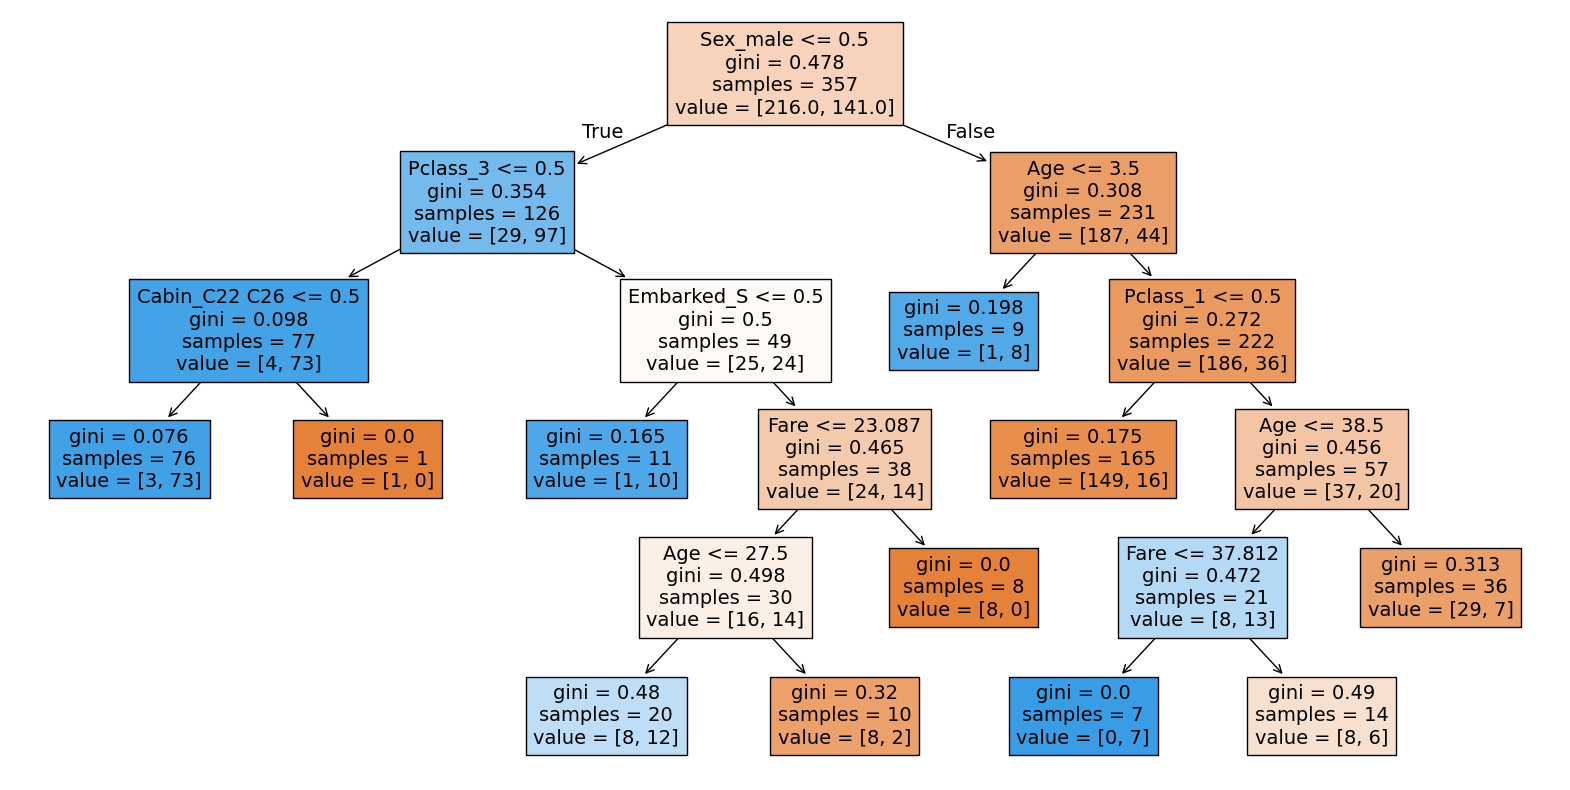

In [47]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(model_3_simple_hold_out,
                   feature_names=X_train.columns.to_list(),
                   filled=True)

### performance metrics of model 3

In [48]:
model_3_pred = model_3_simple_hold_out.predict(X_test)

print(metrics.classification_report(y_test,model_3_pred))
print(metrics.confusion_matrix(y_test,model_3_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       208
           1       0.77      0.68      0.72       149

    accuracy                           0.78       357
   macro avg       0.78      0.76      0.77       357
weighted avg       0.78      0.78      0.78       357

[[177  31]
 [ 48 101]]


## model 4 (simple hold out 50% split and cabin removed)

In [49]:
# another way to drop cabin columns
# notice there are multiple ways to drop columns.

# Drop Cabin
X_train_no_cabin = X_train.drop(list(X_train.filter(regex = '^Cabin')), axis=1, inplace=False)
X_test_no_cabin = X_test.drop(list(X_test.filter(regex = '^Cabin')), axis=1, inplace=False)

### fit

In [50]:
model_4 = tree.DecisionTreeClassifier(random_state=random_state,max_leaf_nodes=11)

model_4 = model_4.fit(X_train_no_cabin, y_train)
print(tree.export_text(model_4, feature_names=X_train_no_cabin.columns.to_list()))

|--- Sex_female <= 0.50
|   |--- Age <= 3.50
|   |   |--- SibSp <= 3.50
|   |   |   |--- class: 1
|   |   |--- SibSp >  3.50
|   |   |   |--- class: 0
|   |--- Age >  3.50
|   |   |--- Pclass_1 <= 0.50
|   |   |   |--- class: 0
|   |   |--- Pclass_1 >  0.50
|   |   |   |--- Age <= 38.50
|   |   |   |   |--- Fare <= 37.81
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Fare >  37.81
|   |   |   |   |   |--- class: 0
|   |   |   |--- Age >  38.50
|   |   |   |   |--- class: 0
|--- Sex_female >  0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- class: 1
|   |--- Pclass_3 >  0.50
|   |   |--- Embarked_S <= 0.50
|   |   |   |--- class: 1
|   |   |--- Embarked_S >  0.50
|   |   |   |--- Fare <= 23.09
|   |   |   |   |--- Age <= 27.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Age >  27.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Fare >  23.09
|   |   |   |   |--- class: 0



### plot

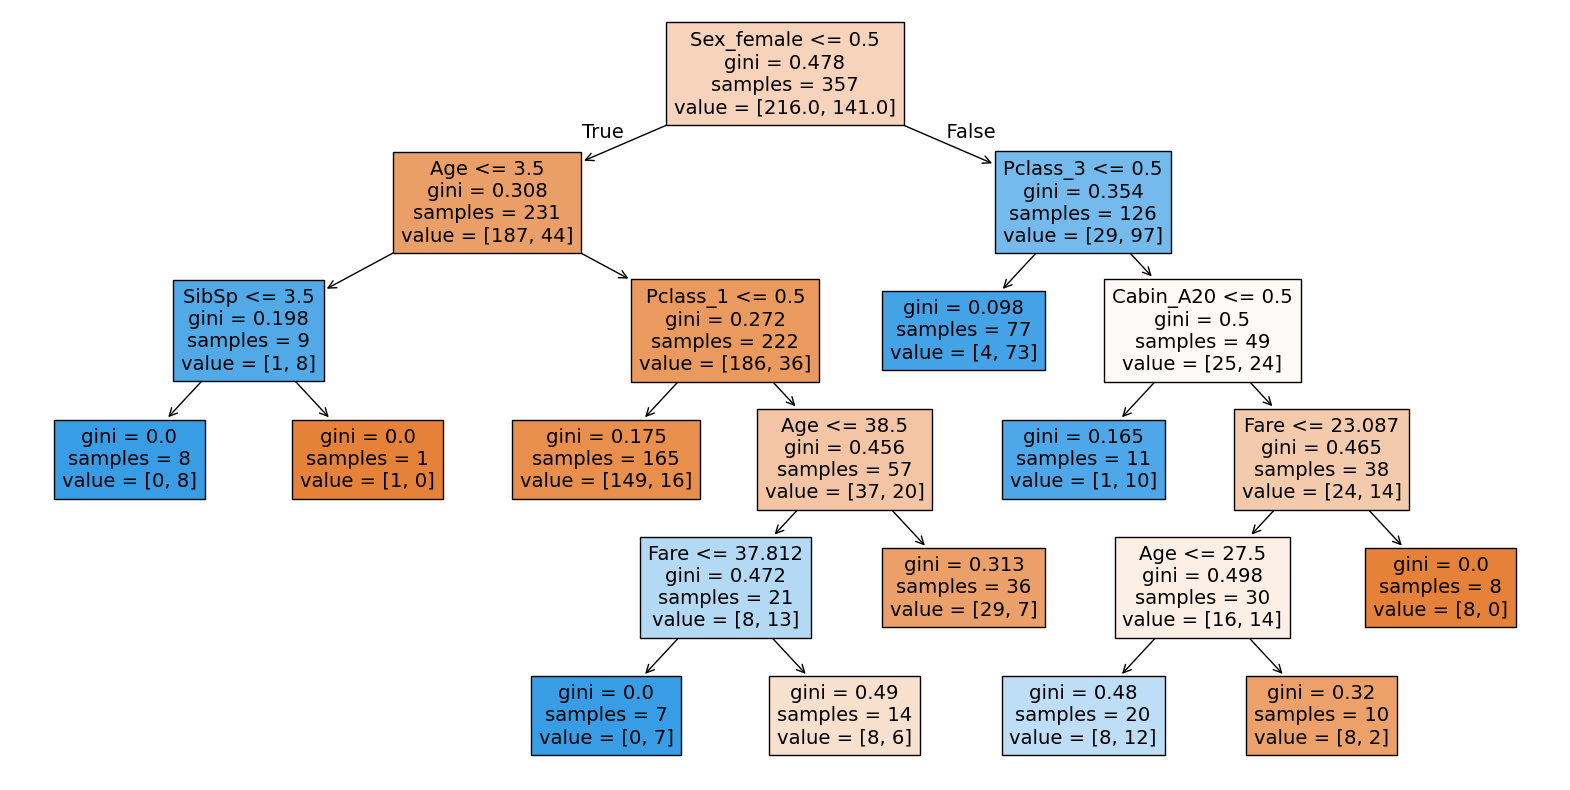

In [51]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(model_4,
                   feature_names=X_train.columns.to_list(),
                   filled=True)

### performance metrics of model 4

In [52]:
# Test set performance metrics
print(metrics.classification_report(y_test,model_4.predict(X_test_no_cabin)))
print(metrics.confusion_matrix(y_test,model_4.predict(X_test_no_cabin)))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       208
           1       0.78      0.67      0.72       149

    accuracy                           0.78       357
   macro avg       0.78      0.77      0.77       357
weighted avg       0.78      0.78      0.78       357

[[179  29]
 [ 49 100]]


# 7 Regularization (tree model pruning)

## model 5 (pruned tree on simple hold out 50%)

In [53]:
# check out alpha level on the default tree sklearn gives us.
# notice it's set to 0!
tree_model = tree.DecisionTreeClassifier(random_state=random_state,max_leaf_nodes=11) #

In [54]:
tree.DecisionTreeClassifier(random_state=random_state,max_leaf_nodes=11,ccp_alpha=.005) # notice we have set a new hyper parameter ccp_alpha

DecisionTreeClassifier(ccp_alpha=0.005, max_leaf_nodes=11, random_state=42)

In [55]:
model_5 = tree.DecisionTreeClassifier(random_state=random_state,max_leaf_nodes=11,ccp_alpha=.01)

### fit

In [56]:
model_5 = model_5.fit(X_train, y_train)
print(tree.export_text(model_5, feature_names=X_train.columns.to_list()))

|--- Sex_male <= 0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- class: 1
|   |--- Pclass_3 >  0.50
|   |   |--- Embarked_S <= 0.50
|   |   |   |--- class: 1
|   |   |--- Embarked_S >  0.50
|   |   |   |--- class: 0
|--- Sex_male >  0.50
|   |--- Age <= 3.50
|   |   |--- class: 1
|   |--- Age >  3.50
|   |   |--- Pclass_1 <= 0.50
|   |   |   |--- class: 0
|   |   |--- Pclass_1 >  0.50
|   |   |   |--- Age <= 38.50
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  38.50
|   |   |   |   |--- class: 0



### Show the tree size.

The model must be fitted prior to getting the node count. We cannot know how many nodes the tree has prior to fitting as there is not "tree" yet.

In [57]:
print("Number of nodes in model_5:", model_5.tree_.node_count)

Number of nodes in model_5: 13


### plot

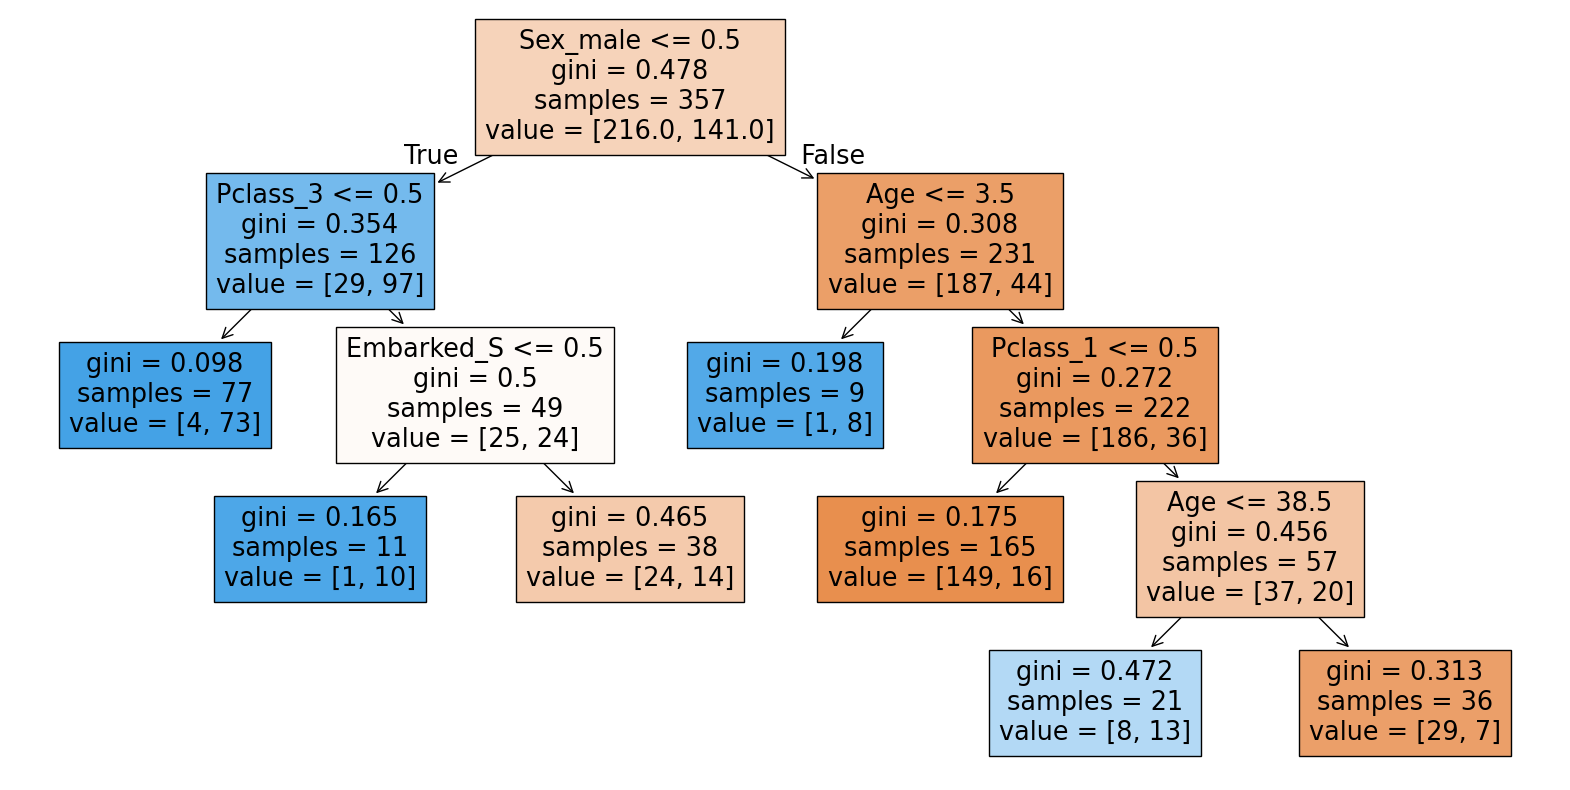

In [58]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(model_5,
                   feature_names=X_train.columns.to_list(),
                   filled=True)

### performance metrics of model 5

In [59]:
# Test set
print(metrics.classification_report(y_test,model_5.predict(X_test)))
print(metrics.confusion_matrix(y_test,model_5.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       208
           1       0.76      0.66      0.71       149

    accuracy                           0.77       357
   macro avg       0.77      0.76      0.76       357
weighted avg       0.77      0.77      0.77       357

[[176  32]
 [ 50  99]]


In [60]:
# Train set
print(metrics.classification_report(y_train,model_5.predict(X_train)))
print(metrics.confusion_matrix(y_train,model_5.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       216
           1       0.88      0.74      0.80       141

    accuracy                           0.86       357
   macro avg       0.86      0.84      0.85       357
weighted avg       0.86      0.86      0.85       357

[[202  14]
 [ 37 104]]


In [61]:
# when viewing the performance metrics above which set did "better"? Why would the model perform better on the train set instead of the test set? What term do we use when this occurs?

The impact of the ccp_alpha parameter

notice that as the ccp_alpha paramater gets larger the number of leaf nodes drops. A larger ccp_alpha prunes the decision tree more than a smaller value. It regularizes the model more strictly.

In [66]:
ccp_alpha = .005
example_tree = tree.DecisionTreeClassifier(random_state=random_state,ccp_alpha=ccp_alpha).fit(X_train, y_train)
print(f"Number of nodes with ccp_alpha set to {ccp_alpha}:", example_tree.tree_.node_count)

ccp_alpha = .05
example_tree = tree.DecisionTreeClassifier(random_state=random_state,ccp_alpha=ccp_alpha).fit(X_train, y_train)
print(f"Number of nodes with ccp_alpha set to {ccp_alpha}:", example_tree.tree_.node_count)

ccp_alpha = .5
example_tree = tree.DecisionTreeClassifier(random_state=random_state,ccp_alpha=ccp_alpha).fit(X_train, y_train)
print(f"Number of nodes with ccp_alpha set to {ccp_alpha}:", example_tree.tree_.node_count)


Number of nodes with ccp_alpha set to 0.005: 21
Number of nodes with ccp_alpha set to 0.05: 3
Number of nodes with ccp_alpha set to 0.5: 1
